In [7]:
import pandas as pd
import csv
import numpy as np
from scipy import ndimage
from numpy import asarray
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pyabf
from datetime import timedelta
import cv2
import os
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from neo.io import AxonIO
from matplotlib.gridspec import GridSpec
import urllib
import neo


In [8]:
def DataFrameNameToString(df):
    # Get the variable name of the DataFrame as a string
    for name, var in globals().items():
        if var is df:
            return name

# Import

In [9]:
file_path_1 = r'D:\230919_firstRecordingsinFlight\5attempt\rec2\r03c002'

file_path_2 = r'D:\230923_Patch\2ndPrep\1strecording\r03c021'

file_path_3 = r'D:\230923_Patch\3rprep\2ndattempt\2ndrecording\r03c322'

file_path_4 = r'D:\231011_Patch\311\r03c311'

In [10]:
df_RE_1 = pd.read_csv(file_path_1 + '\\pupilTracking_21554817_2023_09_19_15_24_13.csv')
df_LE_1 = pd.read_csv (file_path_1 + '\\pupilTracking_21554827_2023_09_19_15_24_05.csv')

df_RE_2 = pd.read_csv(file_path_2 + '\\pupilTracking_21554817_2023_09_22_14_27_29.csv')
df_LE_2 = pd.read_csv (file_path_2 + '\\pupilTracking_21554827_2023_09_22_14_27_22.csv')

df_RE_3 = pd.read_csv(file_path_3 + '\\pupilTracking_21554817_2023_09_22_16_40_07.csv')
df_LE_3 = pd.read_csv (file_path_3 + '\\pupilTracking_21554827_2023_09_22_16_40_16.csv')

df_RE_4 = pd.read_csv(file_path_4 + '\\pupilTracking_21554817_2023_10_11_16_14_28.csv')
df_LE_4 = pd.read_csv (file_path_4 + '\\pupilTracking_21554827_2023_10_11_16_14_36.csv')

In [11]:
DATAFRAMES=[df_RE_1,df_LE_1,df_RE_2,df_LE_2,df_RE_3,df_LE_3,df_RE_4,df_LE_4]

# Add time and frame ID 

In [12]:
def addTimeAndFrame(df_func): # this function adds the the column num_of_frames and run_time_ms
    # First it takes care of the time, here takes'image_time' and convert it to a NumPy array
    time_array = df_func["image_time"].to_numpy()
    # Subtract the first value of 'image_time' from all values in 'time_array'
    time_array = time_array-time_array[0]
    # Add a new column named 'run_time_ms' to the DataFrame and assign the modified 'time_array' as its values
    df_func['run_time_ms']=time_array.tolist()
    
    #Now take care of the frame numbers, convert to numpy array and then basically does the same as before, substract first value and save
    frame_array = df_func["frame_id"].to_numpy()
    frame_array = frame_array-frame_array[0]
    # Add 1 to all values in 'frame_array' to adjust for frame numbering
    frame_array = frame_array+1
    df_func['num_of_frames']=frame_array.tolist()
    return df_func

In [13]:
for df in DATAFRAMES:
    addTimeAndFrame(df)

# Check if recording ran through smoothly

In [14]:
def FrameRateCheck(df_func, name='' , y_lower=15, y_upper=18):
    #Generate name for plot
    df_name = DataFrameNameToString(df)
    
    # Convert to numpy array
    arr = np.array(df_func['image_time'])
    
    # Calculate the differences between consecutive elements in the 'image_time' array
    arr_diff = np.diff(arr)

    # Create and display the plot
    plt.scatter(df_func['num_of_frames'][:-1], arr_diff, s=0.3)
    plt.ylim([y_lower, y_upper])
    plt.title(df_name+" Image Time Differences")
    plt.xlabel('Frame Number')
    plt.ylabel('Time Difference')
    return plt.show()

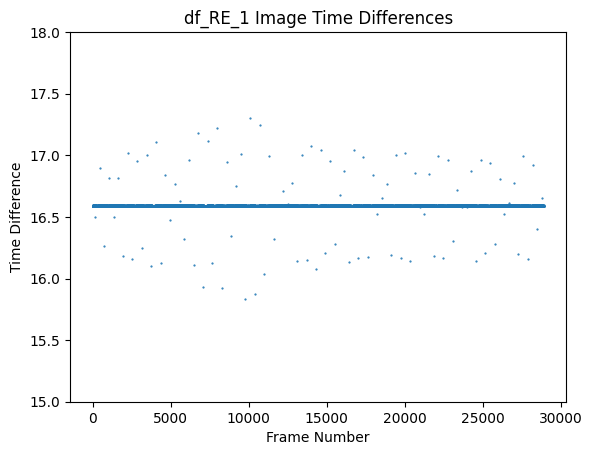

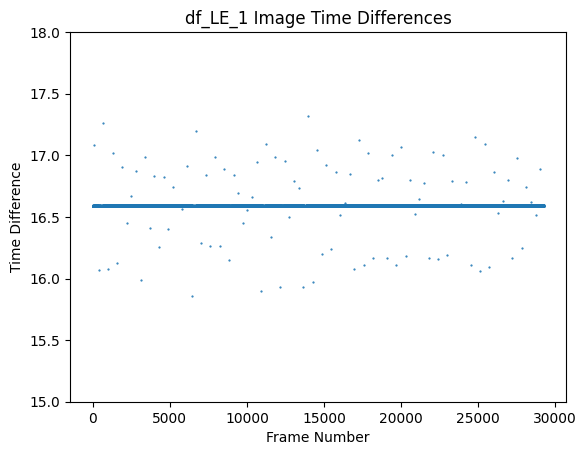

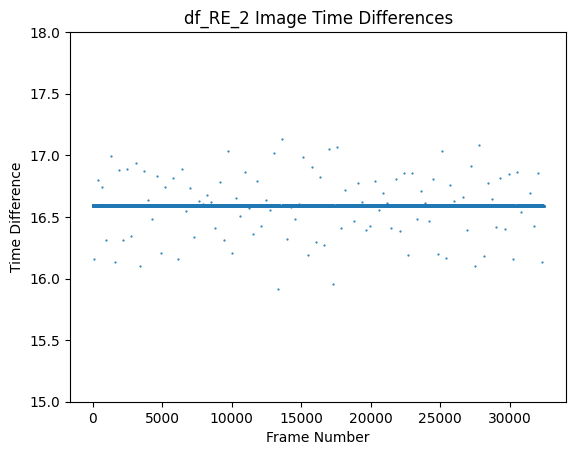

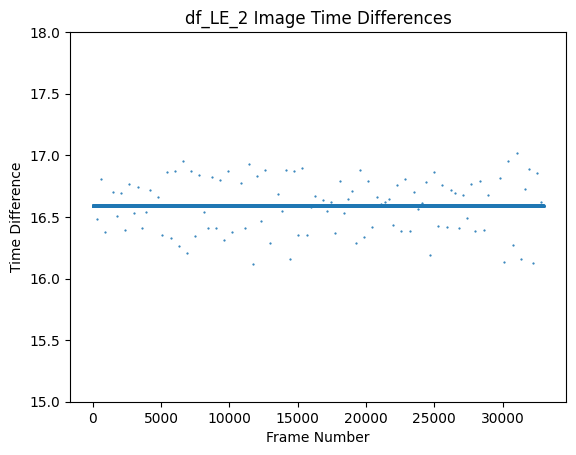

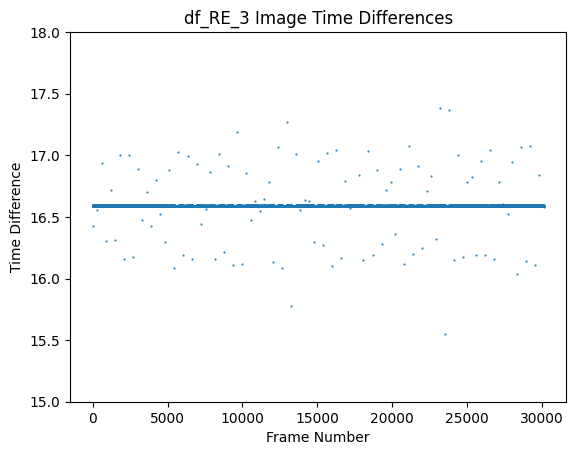

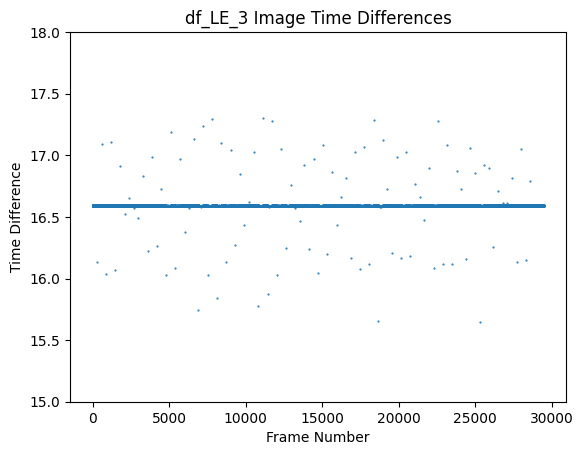

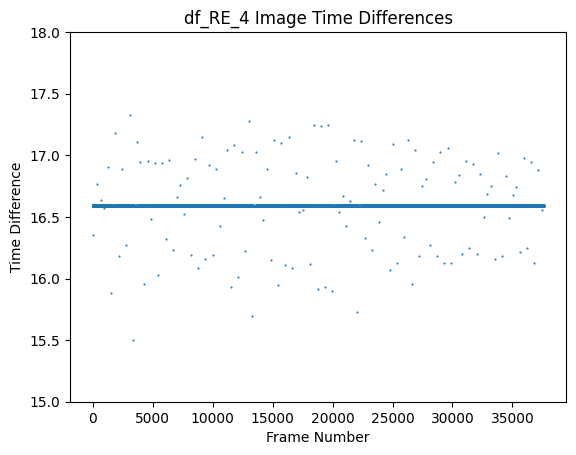

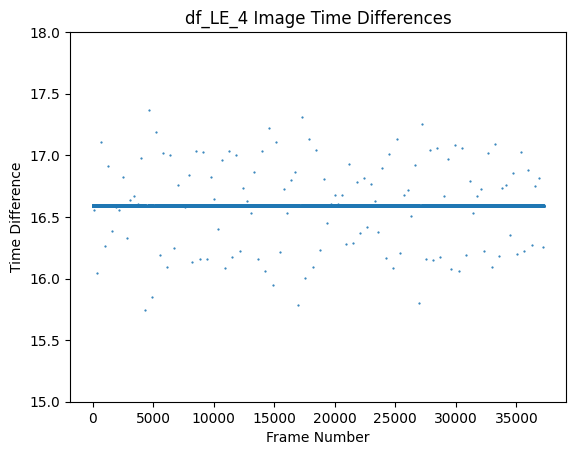

In [15]:
for df in DATAFRAMES:
    FrameRateCheck(df)

# Rotate along the axis -- align with x axis

Note the pixel cooredinate system is not like the math coordinate system, basically inverted at the y axis

In [16]:
def display_image_intensity(df_RE,df_LE):
    
    #Generate name for plot
    df_name_RE = DataFrameNameToString(df_RE)
    df_name_LE = DataFrameNameToString(df_LE)
    
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_RE['num_of_frames'], df_RE['image_intensity'], linewidth=0.5)
    plt.xlim([0, max(df_RE['num_of_frames'])])

    plt.title(df_name_RE+' Image intensity')
    plt.ylabel('Image Intensity')
    plt.xlabel('N° of Frames')

    plt.subplot(1, 2, 2)
    plt.plot(df_LE['num_of_frames'], df_LE['image_intensity'], linewidth=0.5)
    plt.xlim([0, max(df_LE['num_of_frames'])])

    plt.title(df_name_LE+' Image intensity')
    plt.ylabel('Image Intensity')
    plt.xlabel('N° of Frames')

    plt.show()


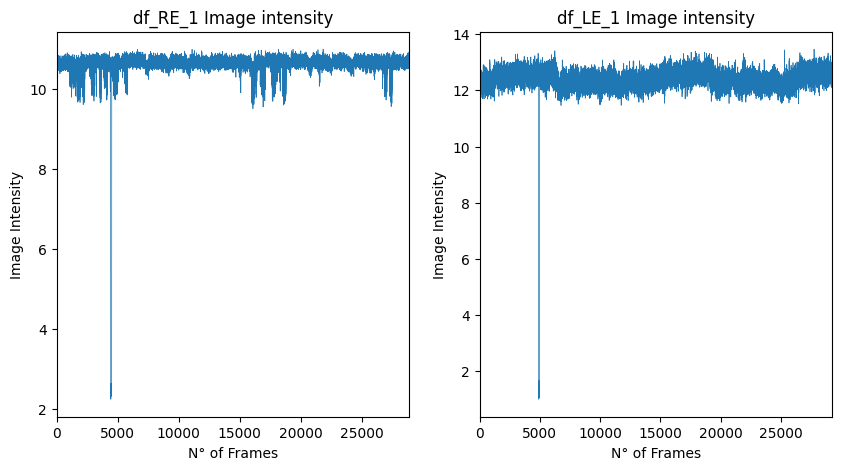

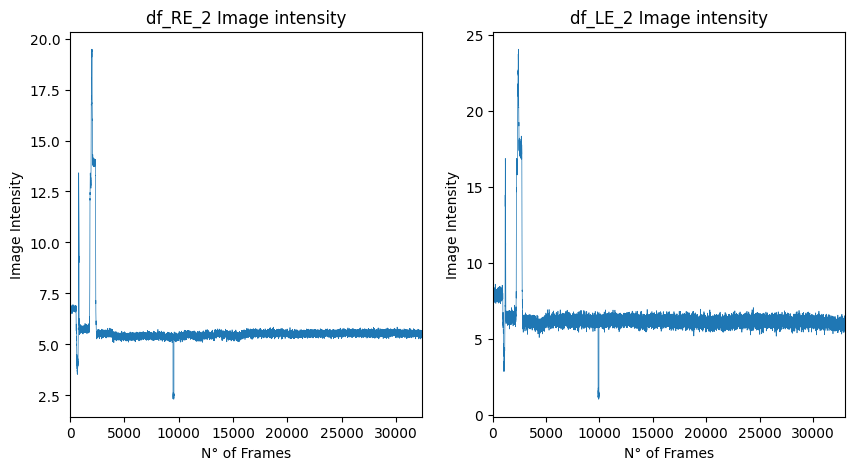

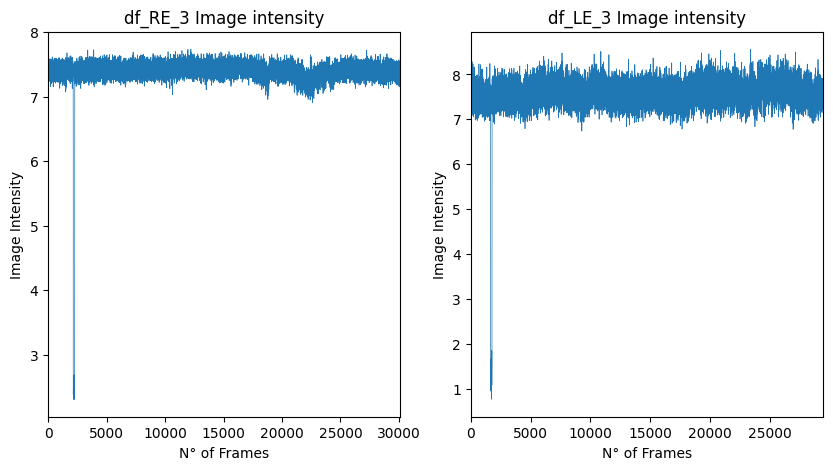

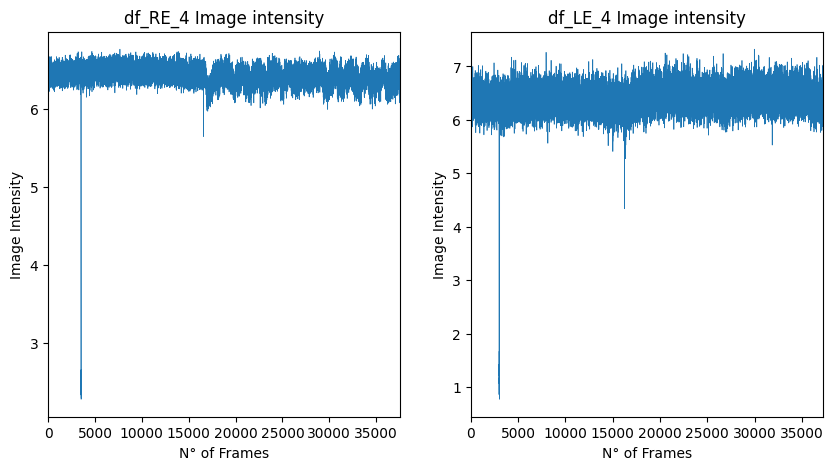

In [17]:
display_image_intensity(df_RE_1, df_LE_1)
display_image_intensity(df_RE_2, df_LE_2)
display_image_intensity(df_RE_3, df_LE_3)
display_image_intensity(df_RE_4, df_LE_4)

# Get the threshold now so I can use that as boundry definition for the point cloud

In [18]:
def find_first_frame(df, column_name, x_axis_name='num_of_frames', adjustment=0, threshold_multiplier=6):
    
    # Generate name for plot
    df_name = DataFrameNameToString(df)
   
    # Calculate threshold
    median_intensity = np.nanmedian(df[column_name])
    q1 = np.nanpercentile(df[column_name], 25)
    q3 = np.nanpercentile(df[column_name], 75)
    iqr_value = q3 - q1
    thresh_intensity = median_intensity - threshold_multiplier * iqr_value
    thresh_intensity = thresh_intensity - adjustment  # for noisy recordings

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot the original data with the threshold
    axes[0].plot(df[x_axis_name], df[column_name])
    axes[0].axhline(y=thresh_intensity, color='r')
    axes[0].set_title('Original Data with Threshold of ' + df_name)
    axes[0].set_xlabel(x_axis_name)
    axes[0].set_ylabel(column_name)

    # Find the first frame number
    first_frame_number = np.where(df[column_name] < thresh_intensity)[0][0]
    first_frame_number = first_frame_number+1 #Add that do the first frame is below the threshold

    # Plot a zoomed-in view around the first frame with a vertical line
    zoom_start = max(0, first_frame_number - 2)
    zoom_end = min(len(df), first_frame_number + 2)
    axes[1].plot(df[x_axis_name][zoom_start:zoom_end], df[column_name][zoom_start:zoom_end])
    axes[1].axhline(y=thresh_intensity, color='r')
    axes[1].axvline(x=first_frame_number, color='g', linestyle='--', label='First Frame')
    axes[1].set_title('Zoomed-In View of ' + df_name)
    axes[1].set_xlabel(x_axis_name)
    axes[1].set_ylabel(column_name)
    axes[1].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()
    
    print("The number of the first frame for "+ df_name+" recording is ", first_frame_number)

    return first_frame_number


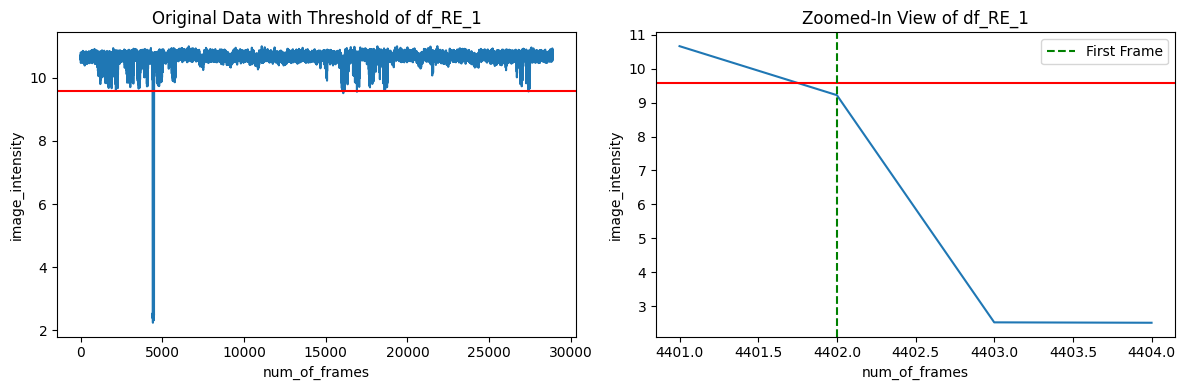

The number of the first frame for df_RE_1 recording is  4402


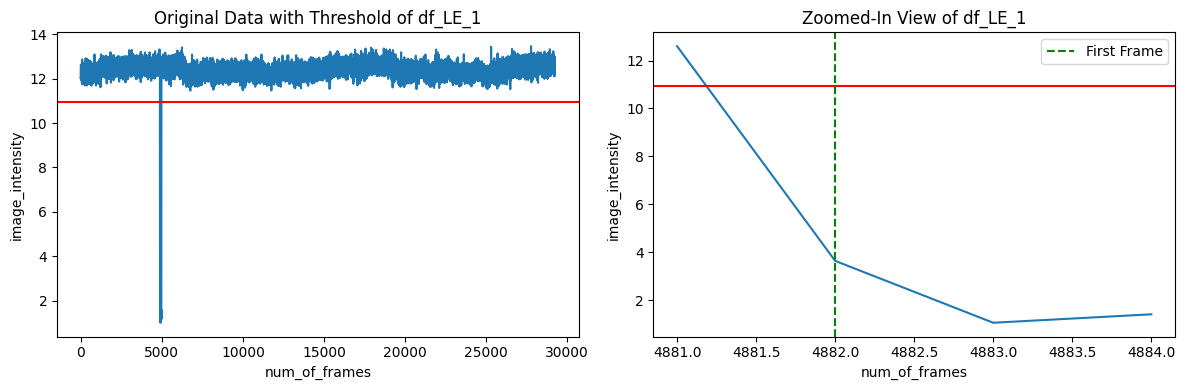

The number of the first frame for df_LE_1 recording is  4882


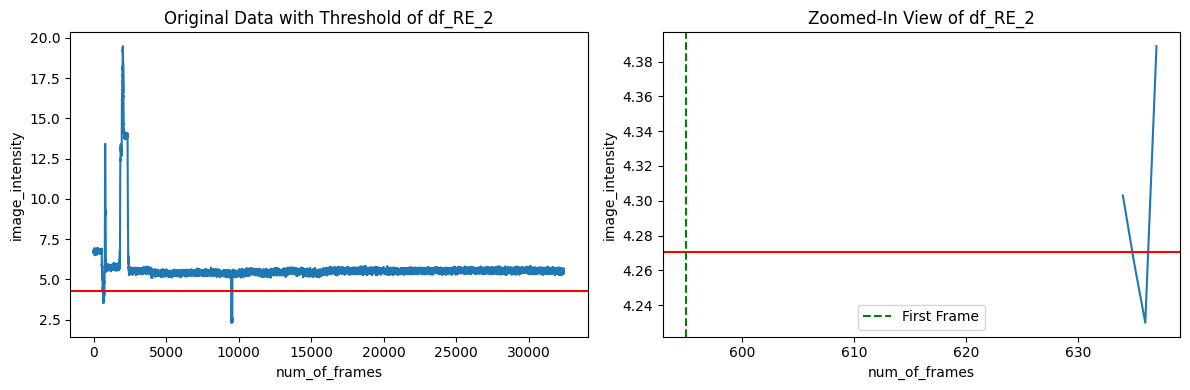

The number of the first frame for df_RE_2 recording is  595


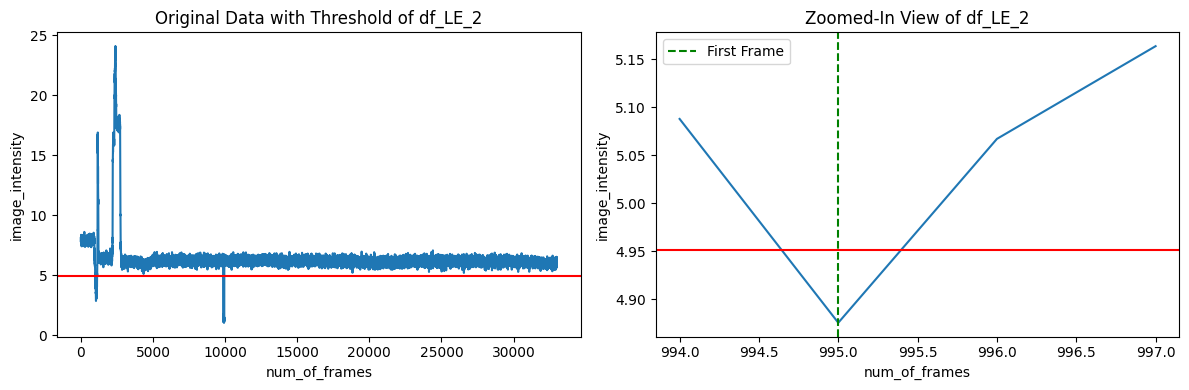

The number of the first frame for df_LE_2 recording is  995


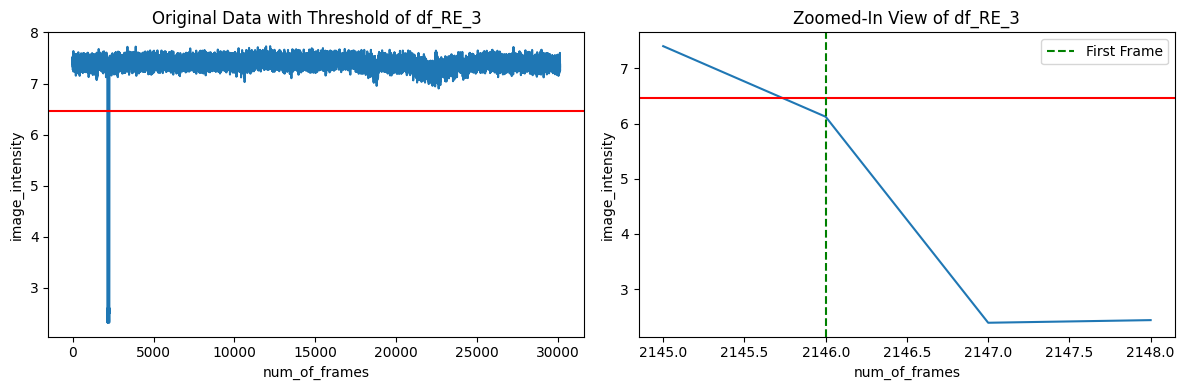

The number of the first frame for df_RE_3 recording is  2146


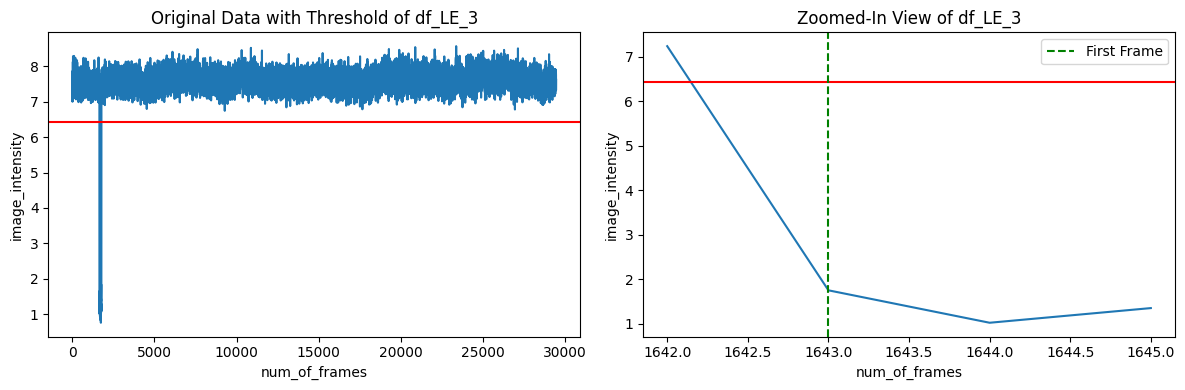

The number of the first frame for df_LE_3 recording is  1643


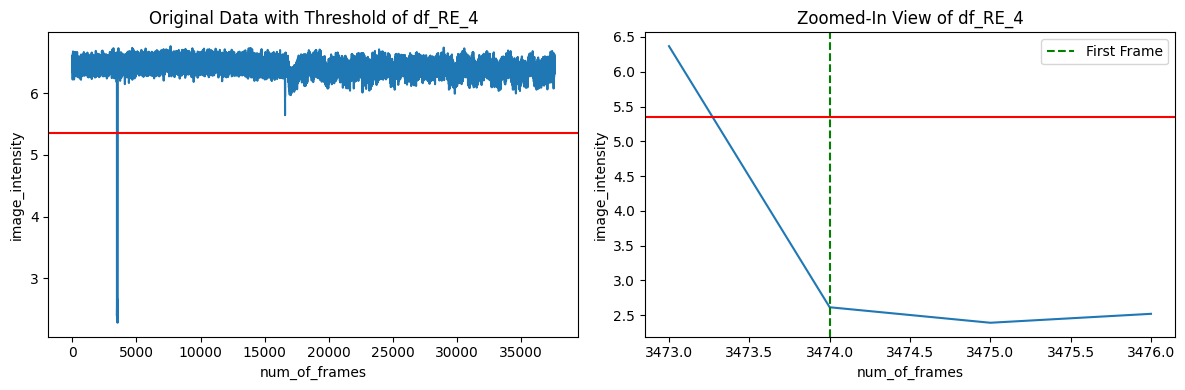

The number of the first frame for df_RE_4 recording is  3474


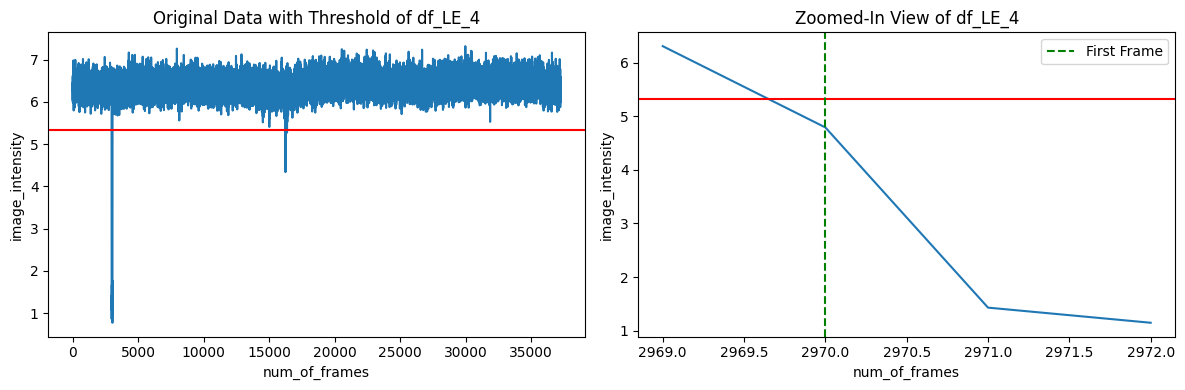

The number of the first frame for df_LE_4 recording is  2970


In [19]:
first_frame_df_RE1=find_first_frame(df_RE_1,'image_intensity', threshold_multiplier=8)
first_frame_df_LE1=find_first_frame(df_LE_1,'image_intensity', threshold_multiplier=4)

first_frame_df_RE2=find_first_frame(df_RE_2,'image_intensity', threshold_multiplier=8)
first_frame_df_LE2=find_first_frame(df_LE_2,'image_intensity', threshold_multiplier=4)

first_frame_df_RE3=find_first_frame(df_RE_3,'image_intensity', threshold_multiplier=8)
first_frame_df_LE3=find_first_frame(df_LE_3,'image_intensity', threshold_multiplier=4)

first_frame_df_RE4=find_first_frame(df_RE_4,'image_intensity', threshold_multiplier=8)
first_frame_df_LE4=find_first_frame(df_LE_4,'image_intensity', threshold_multiplier=4)

# Add Zeroed time column to the df

In [20]:
df_RE_1['time_milliseconds_zero'] = (df_RE_1['run_time_ms'] - df_RE_1['run_time_ms'].iloc[first_frame_df_RE1])
df_LE_1['time_milliseconds_zero'] = (df_LE_1['run_time_ms'] - df_LE_1['run_time_ms'].iloc[first_frame_df_LE1])

In [21]:
df_RE_3['time_milliseconds_zero'] = (df_RE_3['run_time_ms'] - df_RE_3['run_time_ms'].iloc[first_frame_df_RE3])
df_LE_3['time_milliseconds_zero'] = (df_LE_3['run_time_ms'] - df_LE_3['run_time_ms'].iloc[first_frame_df_LE3])

In [22]:
df_RE_4['time_milliseconds_zero'] = (df_RE_4['run_time_ms'] - df_RE_4['run_time_ms'].iloc[first_frame_df_RE4])

In [23]:
def GetLinReg(df, start, finish=-1 ):
    
    #Generate name for plot
    df_name = DataFrameNameToString(df)
    
    start=start+400 # makes sure that the tracking from the blackout is not visible
    
    # Defining data for linear Regression and converting them into numpy arrays
    x_LinReg=df[start:finish]['pupil_x'].to_numpy()
    y_LinReg=df[start:finish]['pupil_y'].to_numpy()

    #Resahpe data because 2D array is needed
    x_LinReg=x_LinReg.reshape((-1,1))
    y_LinReg=y_LinReg.reshape((-1,1))
    
    # Create the model & fit it 
    LinReg = LinearRegression().fit(x_LinReg, y_LinReg)

    # Get results
    r_sq = LinReg.score(x_LinReg, y_LinReg)
    slope=f"{LinReg.coef_}"
    slope=float(slope[+2:-2])
    interception=f"{LinReg.intercept_}"
    interception=float(interception[+1:-1])
    angle=np.degrees(np.arctan(slope))
    
    print(f"coefficient of determination: {r_sq}")
    print('slope: ', slope)
    print('interception: ', interception)
    print('angle:',angle, 'in degrees')
    
    
    plt.scatter(df[start:finish]['pupil_x'],df[start:finish]['pupil_y'], s=0.01)
    plt.style.use('default')
    # Add regression
    a=df[start:finish]['pupil_x']
    b= slope*a+interception
    plt.plot(a,b, 'g', linewidth=2)
    #How to mess with axis
    plt.xlabel('x-Position')
    plt.ylabel('y-Position')
    plt.title('Untransformed point cloud for '+df_name+' with regression')

    plt.show()
    return angle


Removed dataset 2 here because data corrupted?--> No time

coefficient of determination: 0.06696100757693502
slope:  0.7029
interception:  43.9918
angle: 35.10338361038722 in degrees


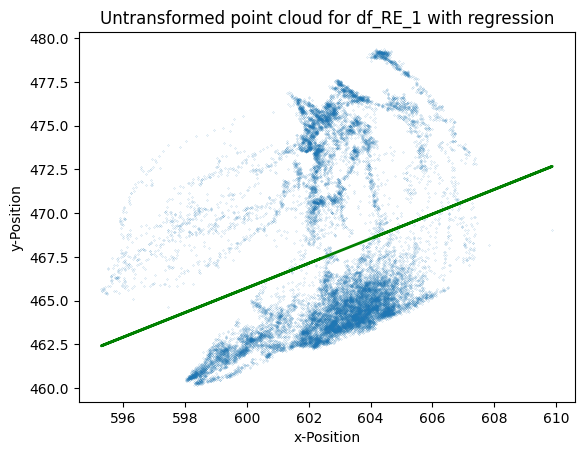

coefficient of determination: 0.12369919378350469
slope:  -0.6802
interception:  953.5584
angle: -34.22353725979918 in degrees


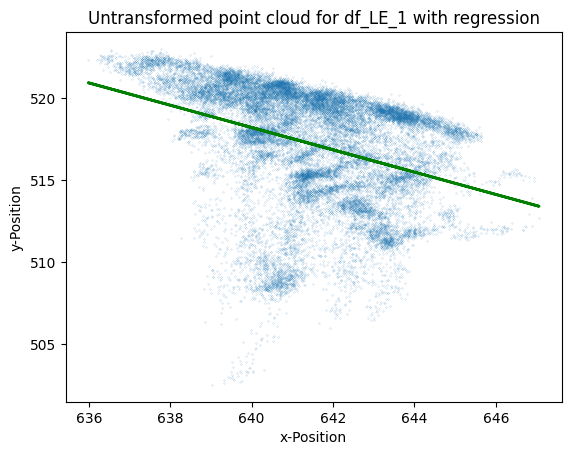

coefficient of determination: 0.00026785156803543764
slope:  0.0513
interception:  543.2413
angle: 2.9366991338602397 in degrees


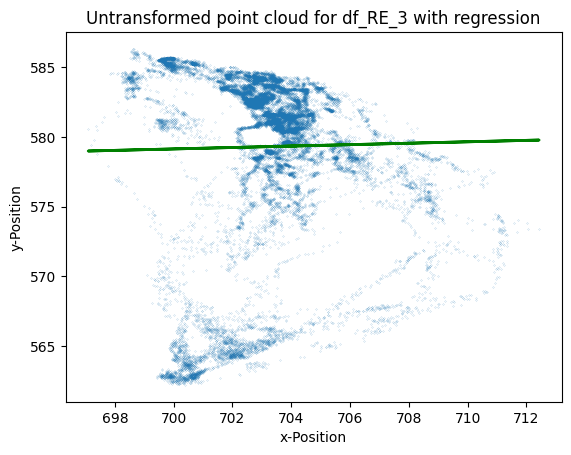

coefficient of determination: 0.012392348285403032
slope:  -0.1936
interception:  617.7211
angle: -10.956913037879495 in degrees


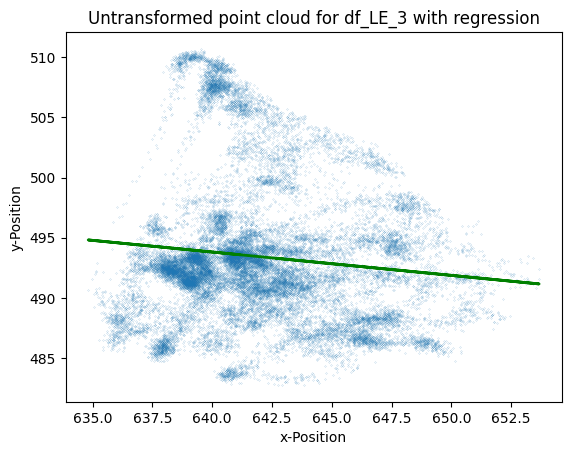

coefficient of determination: 0.8628014720657802
slope:  0.5517
interception:  145.7374
angle: 28.885521496902502 in degrees


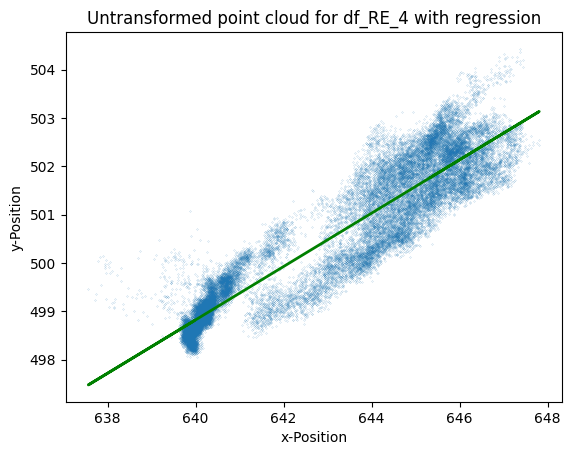

In [24]:
angle_RE_1=GetLinReg(df_RE_1,first_frame_df_RE1)
angle_LE_1=GetLinReg(df_LE_1,first_frame_df_LE1)


angle_RE_3=GetLinReg(df_RE_3,first_frame_df_RE3)
angle_LE_3=GetLinReg(df_LE_3,first_frame_df_LE3)

angle_RE_4=GetLinReg(df_RE_4,first_frame_df_RE4)


Also remove the data for df_LE_4--> No time

In [25]:
def Transformer(df, start, angle,finish=-1):
    # Define a transformation function that rotates pupil_x and pupil_y values
    # around the origin (0, 0) by the specified angle in degrees.
    # This transformation is applied to a portion of the DataFrame (from start to finish).
    
    #Generate name for plot
    df_name = DataFrameNameToString(df)

    # Calculate the transformed pupil_x values
    pupil_x_tranfo = (df['pupil_x'] - df['pupil_x'].min()) * np.cos(np.radians(-angle)) - (df['pupil_y'] - df['pupil_y'].min()) * np.sin(np.radians(-angle))

    # Calculate the transformed pupil_y values
    pupil_y_tranfo = (df['pupil_x'] - df['pupil_x'].min()) * np.sin(np.radians(-angle)) + (df['pupil_y'] - df['pupil_y'].min()) * np.cos(np.radians(-angle))

    # Assign the transformed pupil_x and pupil_y values to new columns in the DataFrame
    df['pupil_x_tranfo'] = pupil_x_tranfo
    df['pupil_y_tranfo'] = pupil_y_tranfo
    
    start=start+400

    # Create a scatter plot of the transformed pupil_x and pupil_y values using a subset of the DataFrame
    plt.scatter(df[start:finish]['pupil_x_tranfo'], df[start:finish]['pupil_y_tranfo'], s=0.01)
    plt.style.use('default')
    plt.title('Transformed point cloud for '+df_name)
    

    return df


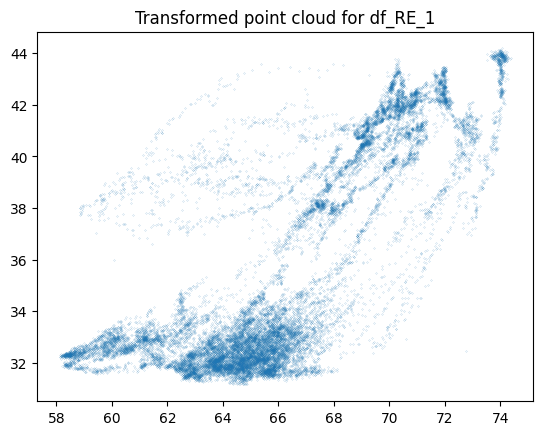

In [26]:
df_RE_1=Transformer(df_RE_1,first_frame_df_RE1,angle_RE_1)

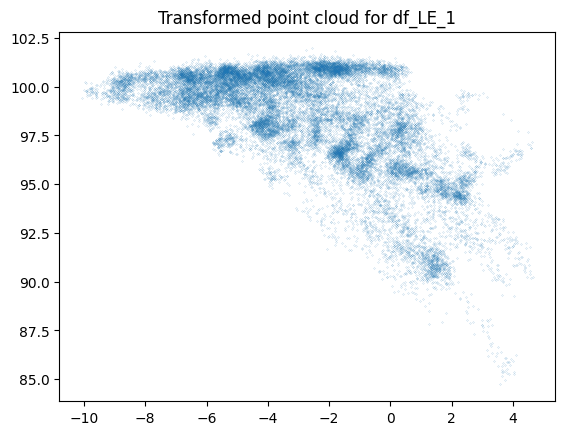

In [27]:
df_LE_1=Transformer(df_LE_1,first_frame_df_LE1,angle_LE_1)

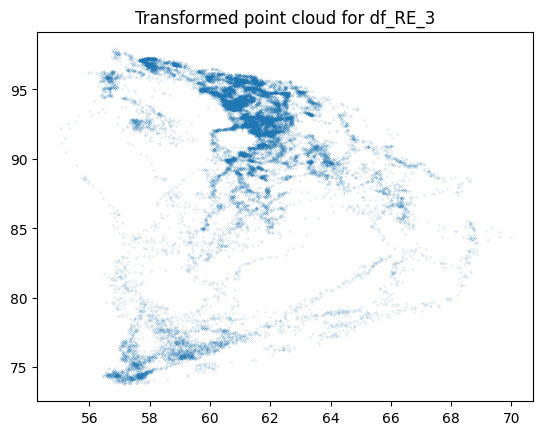

In [28]:
df_RE_3=Transformer(df_RE_3,first_frame_df_RE3,angle_RE_3)

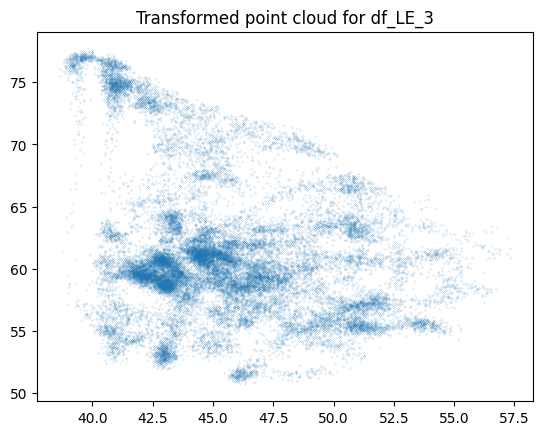

In [29]:
df_LE_3=Transformer(df_LE_3,first_frame_df_LE3,angle_LE_3)

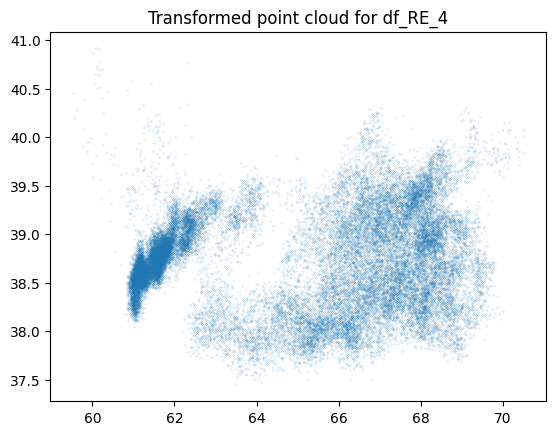

In [30]:
df_RE_4=Transformer(df_RE_4,first_frame_df_RE4,angle_RE_4)

In [31]:
def TransformerCheck(df,UpperYlim=20,LowerYLim=-20):
    
    #Generate name for plot
    df_name = DataFrameNameToString(df)

    # Create a figure with two subplots in a single row for each x and y coordinate
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figure size as needed

    # Plot the x-coordinate comparison
    axes[0].scatter(df['num_of_frames'], df['pupil_x'] - df['pupil_x'][0], s=0.5, label='raw')
    axes[0].scatter(df['num_of_frames'], df['pupil_x_tranfo'] - df['pupil_x_tranfo'][0], s=0.5, label='transformed')
    axes[0].set_title('Comparison x position raw and transformed for '+df_name)
    axes[0].set_ylabel('pupil_x')
    axes[0].set_xlabel('N° of frames')
    axes[0].legend()
    axes[0].set_ylim(LowerYLim, UpperYlim)

    # Plot the y-coordinate comparison
    axes[1].scatter(df['num_of_frames'], df['pupil_y'] - df['pupil_y'][0], s=0.5, label='raw')
    axes[1].scatter(df['num_of_frames'], df['pupil_y_tranfo'] - df['pupil_y_tranfo'][0], s=0.5, label='transformed')
    axes[1].set_title('Comparison y position raw and transformed for '+df_name)
    axes[1].set_ylabel('pupil_y')
    axes[1].set_xlabel('N° of frames')
    axes[1].legend()
    axes[1].set_ylim(LowerYLim, UpperYlim)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()


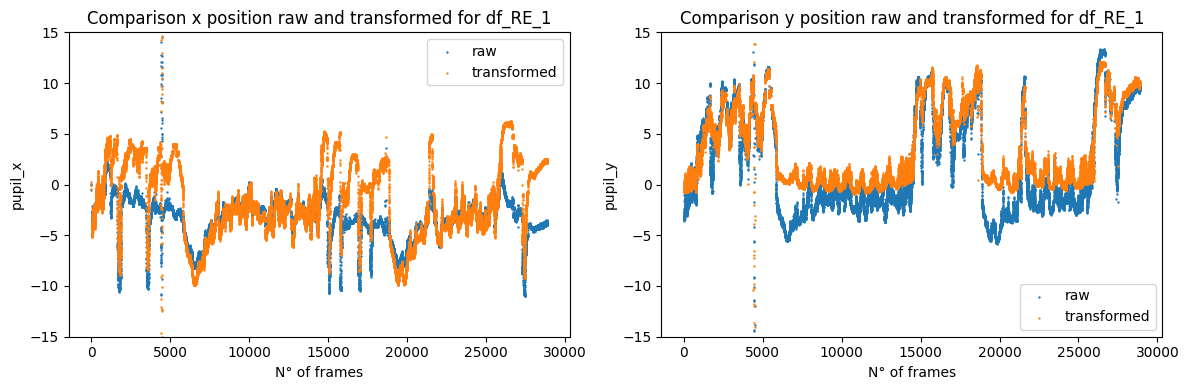

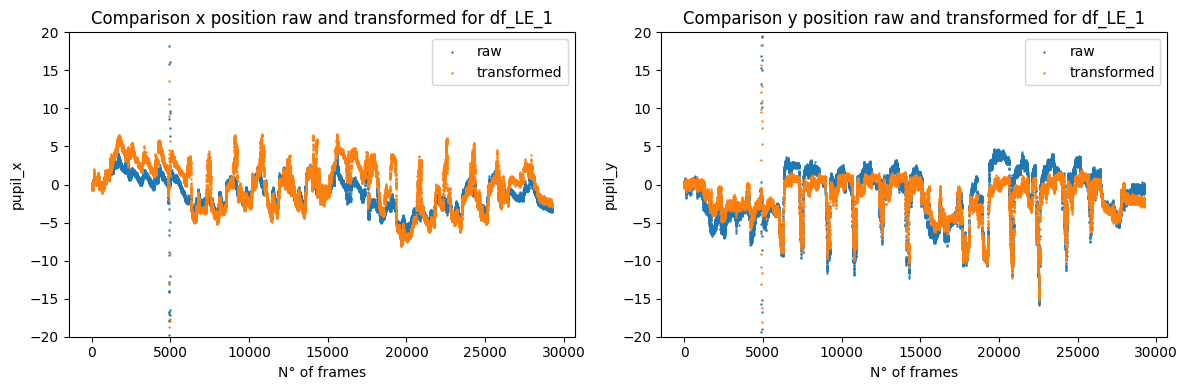

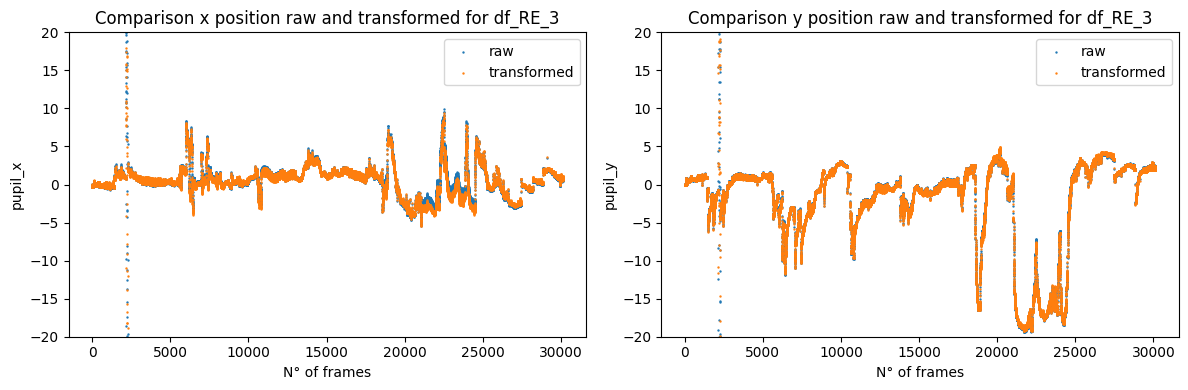

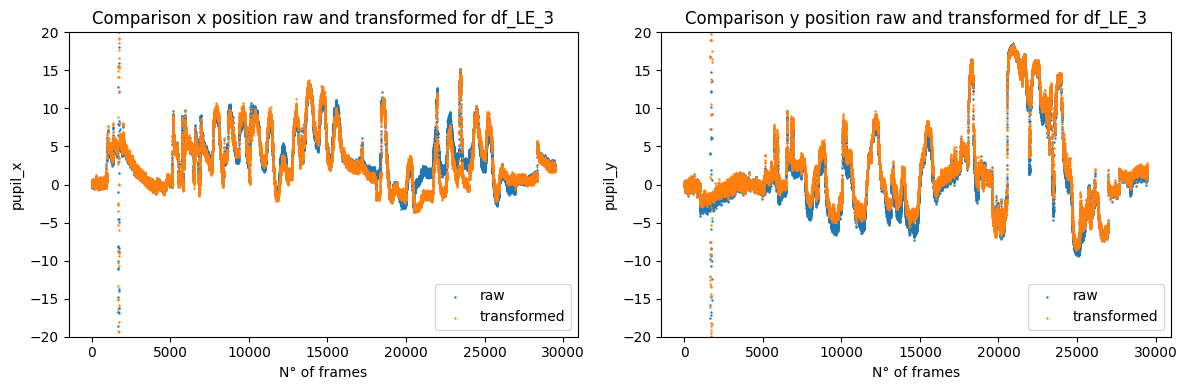

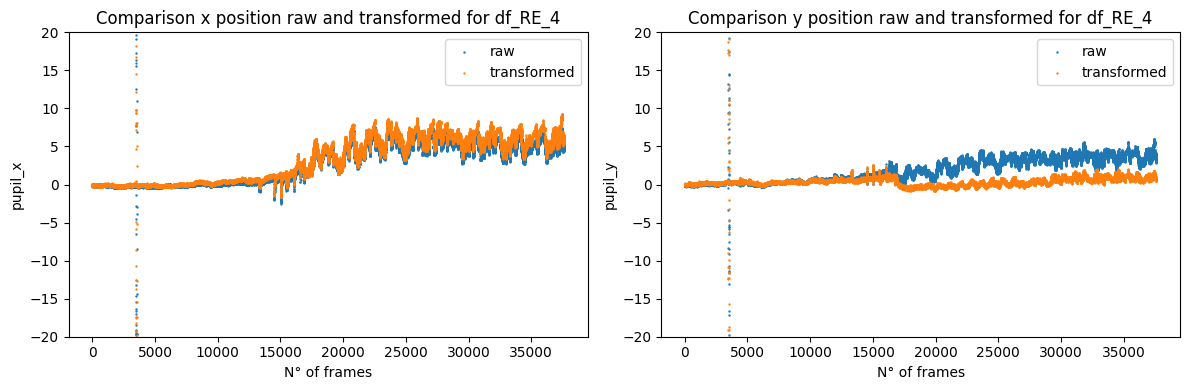

In [32]:
TransformerCheck(df_RE_1,UpperYlim=15, LowerYLim=-15)
TransformerCheck(df_LE_1)

TransformerCheck(df_RE_3)
TransformerCheck(df_LE_3)

TransformerCheck(df_RE_4)

# Transform pixels into degrees

Counted once for this 28 pixels = 15 degrees

In [33]:
def transform_pix_to_degrees(df, x_col='pupil_x_tranfo', y_col='pupil_y_tranfo', pixels =28):
    df['pupil_RE_x_corrected'] = (df[x_col] / pixels) * 15 #makes a new column called 'pupil_RE_x_corrected'and converts pixels into degrees
    df_median_x = df['pupil_RE_x_corrected'].median() # calculates the median
    df['pupil_RE_x_corrected'] = df['pupil_RE_x_corrected'] - df_median_x #substracts median from the new column 

    df['pupil_RE_y_corrected'] = (df[y_col] / pixels) * 15
    df_median_y = df['pupil_RE_y_corrected'].median()
    df['pupil_RE_y_corrected'] = df['pupil_RE_y_corrected'] - df_median_y

    return df

In [34]:
df_RE_1=transform_pix_to_degrees(df_RE_1)
df_LE_1=transform_pix_to_degrees(df_LE_1)

df_RE_3=transform_pix_to_degrees(df_RE_3)
df_LE_3=transform_pix_to_degrees(df_LE_3)

df_RE_4=transform_pix_to_degrees(df_RE_4)



# Removing columns before saving

In [35]:
columns_to_remove = ['pupil_x', 'pupil_y', 'frame_id', 'pupil_size', 'process_time', 'image_time', 'run_time_ms','pupil_y_tranfo','pupil_x_tranfo','image_intensity']

df_RE_1 = df_RE_1.drop(columns=columns_to_remove)
df_LE_1 = df_LE_1.drop(columns=columns_to_remove)

df_RE_3 = df_RE_3.drop(columns=columns_to_remove)
df_LE_3 = df_LE_3.drop(columns=columns_to_remove)

df_RE_4 = df_RE_4.drop(columns=columns_to_remove)


# save dfs at .csv





In [36]:
file_path_1 = r'D:\230919_firstRecordingsinFlight\5attempt\rec2\r03c002'

file_path_2 = r'D:\230923_Patch\2ndPrep\1strecording\r03c021'

file_path_3 = r'D:\230923_Patch\3rprep\2ndattempt\2ndrecording\r03c322'

file_path_4 = r'D:\231011_Patch\311\r03c311'

In [37]:
file_path_RE_1 = file_path_1 + '\\df_RE.csv'
file_path_LE_1 = file_path_1 + '\\df_LE.csv'
df_RE_1.to_csv(file_path_RE_1, index=False)
df_LE_1.to_csv(file_path_LE_1, index=False)


file_path_RE_3 = file_path_3 + '\\df_RE.csv'
file_path_LE_3 = file_path_3 + '\\df_LE.csv'
df_RE_3.to_csv(file_path_RE_3, index=False)
df_LE_3.to_csv(file_path_LE_3, index=False)

file_path_RE_4 = file_path_4 + '\\df_RE.csv'
df_RE_4.to_csv(file_path_RE_4, index=False)



In [38]:
print(first_frame_df_RE1,first_frame_df_LE1, first_frame_df_RE3, first_frame_df_LE3, first_frame_df_RE4, first_frame_df_LE4)

4402 4882 2146 1643 3474 2970
